In [1]:
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    MultibodyPlant,
    InverseDynamicsController,
    Diagram,
    LeafSystem,
    Integrator,
    JacobianWrtVariable
)
import numpy as np
import os
from manipulation.utils import RenderDiagram

In [2]:
meshcat = StartMeshcat()
running_as_notebook = True


INFO:drake:Meshcat listening for connections at http://localhost:7001


In [20]:
# This is the pseudoinverse controller from the manipulation course
class PseudoInverseController(LeafSystem):
    def __init__(self, plant, model_name="low-cost-arm", ee_body_name="gripper-static-motor_v2_1"):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._low_cost_robot = plant.GetModelInstanceByName(model_name)
        self._G = plant.GetBodyByName(ee_body_name).body_frame()
        self._W = plant.world_frame()

        self.DeclareVectorInputPort("low_cost_robot.position", plant.num_positions())
        self.DeclareVectorOutputPort("low_cost_robot.velocity", plant.num_positions(), self.CalcOutput)

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)
        self._plant.SetPositions(self._plant_context, self._low_cost_robot, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kQDot,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        # J_G = J_G[:, 0:]  # Ignore gripper terms

        V_G_desired = np.array(
            [
                0,  # rotation about x
                0,  # rotation about y
                0,  # rotation about z
                0.1,  # x
                0.1,  # y
                0.0, # z
            ]
        ) 
        v = np.linalg.pinv(J_G).dot(V_G_desired)
        # print(v)
        output.SetFromVector(v)


# Turns out this just doesn't make sense unless I can figure out how to give pose commands to the sim.

In [11]:
# Have separate classes for this so you can separate the integrator from the velocity/ position command.
class ExtractPositionFromState(LeafSystem):
    def __init__(self, ):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("estimated_state", 10)
        self.DeclareVectorOutputPort("position", 5, self.CalcOutput)

    def CalcOutput(self, context, output):
        full_state = self.get_input_port().Eval(context)
        output.SetFromVector(full_state[:5])

class ExtractStateFromPosition(LeafSystem):
    def __init__(self, ):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("low_cost_robot.desired_position", 5)
        self.DeclareVectorOutputPort("low_cost_robot.desired_state", 10, self.CalcOutput)

    def CalcOutput(self, context, output):
        position_only = self.get_input_port().Eval(context)
        output.SetFromVector(np.hstack((position_only, 0 * position_only)))

In [34]:
def jacobian_controller_example():
    # Control
    builder = DiagramBuilder()
    
    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
    plant.Finalize()
    
    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [150] * plant.num_positions()
    static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    static_controller.set_name("static_controller")

    controller = builder.AddSystem(PseudoInverseController(plant))
    integrator = builder.AddSystem(Integrator(5))
    pos_from_state = builder.AddSystem(ExtractPositionFromState())
    state_from_pos = builder.AddSystem(ExtractStateFromPosition())
    
    builder.Connect(
        plant.get_state_output_port(robot_model),
        static_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        static_controller.get_output_port_control(), plant.get_actuation_input_port()
    )

    builder.Connect(controller.get_output_port(), integrator.get_input_port())
    builder.Connect(integrator.get_output_port(), state_from_pos.get_input_port())
    builder.Connect(state_from_pos.get_output_port(), static_controller.get_input_port(1))
    builder.Connect(plant.get_state_output_port(robot_model), pos_from_state.get_input_port())
    builder.Connect(pos_from_state.get_output_port(), controller.get_input_port())
    
    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    
    # RenderDiagram(diagram)
    integrator.set_integral_value(
        integrator.GetMyContextFromRoot(context),
        plant.GetPositions(
            plant.GetMyContextFromRoot(context),
            plant.GetModelInstanceByName("low-cost-arm"),
        ),
    )

    

    meshcat.StartRecording(set_visualizations_while_recording=True)
    simulator.AdvanceTo(100 if running_as_notebook else 0.1)
    meshcat.PublishRecording()
jacobian_controller_example()


## Set up functions to build "Diagrams" for the Sim/ Real Robot

In [13]:
# Utility leaf systems
class TruncateVec(LeafSystem):
    def __init__(self, input_dims, output_dims):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("input", input_dims)
        self.DeclareVectorOutputPort("output", output_dims, self.CalcOutput)
        self.input_dims = input_dims
        self.output_dims = output_dims

    def CalcOutput(self, context, output):
        full_state = self.get_input_port().Eval(context)
        output.SetFromVector(full_state[:self.output_dims]) # TODO: support arbitrary slicing

class ZeroExtendVec(LeafSystem):
    def __init__(self, input_dims, output_dims):
        LeafSystem.__init__(self)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.DeclareVectorInputPort("input", input_dims)
        self.DeclareVectorOutputPort("output", output_dims, self.CalcOutput)

    def CalcOutput(self, context, output):
        input_vec = self.get_input_port(0).Eval(context)
        output.SetFromVector(np.hstack((input_vec, [0] * (self.output_dims - self.input_dims))))


class Identity(TruncateVec):
    def __init__(self, dims):
        TruncateVec.__init__(self, dims, dims)
        

In [14]:
# Setting up functions to build the robot diagram in sim
def build_sim_robot(meshcat):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            "file:///Users/raghav/Documents/projects/robot_arm/low_cost_robot/drake_setup/low-cost-arm.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link"))
    plant.Finalize()
    
    low_cost_robot = plant.GetModelInstanceByName("low-cost-arm")
        
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [150] * plant.num_positions()
    static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    extend_pos = builder.AddSystem(ZeroExtendVec(5, 10))
    truncate_state = builder.AddSystem(TruncateVec(10, 5))

    builder.ExportInput(extend_pos.get_input_port(), "desired_position")
    builder.ExportOutput(truncate_state.get_output_port(), "measured_position")

    # Connect the robot state to the ID controller
    builder.Connect(
        plant.get_state_output_port(low_cost_robot),
        static_controller.get_input_port_estimated_state(),
    )

    # Connect the ID output to the plant
    builder.Connect(
        static_controller.get_output_port_control(), 
        plant.get_actuation_input_port()
    )

    builder.Connect(
        extend_pos.get_output_port(),
        static_controller.get_input_port(1)
    )

    builder.Connect(
        plant.get_state_output_port(low_cost_robot),
        truncate_state.get_input_port()
    )

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    diagram.set_name("low-cost-robot (sim)")
    return diagram, plant


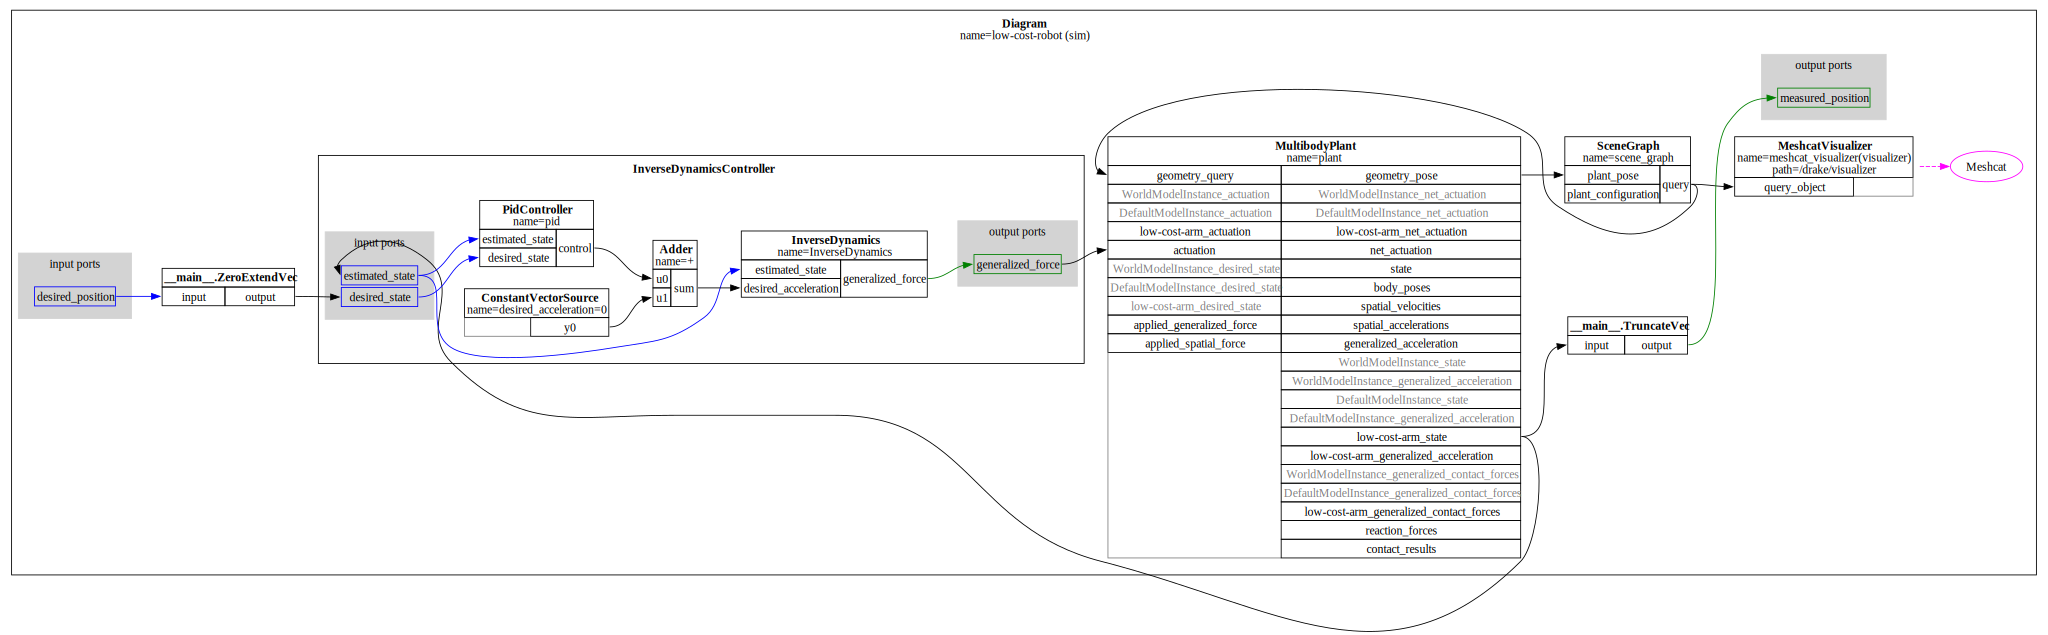

In [15]:
RenderDiagram(build_sim_robot(meshcat)[0])

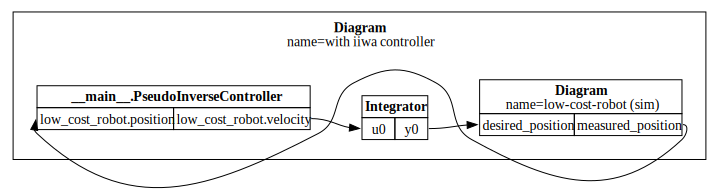

In [16]:
def jacobian_controller_example():
    # Control
    builder = DiagramBuilder()
    robot_diagram, plant = build_sim_robot(meshcat)
    controller = builder.AddSystem(PseudoInverseController(plant))
    integrator = builder.AddSystem(Integrator(plant.num_positions()))
    robot_diagram = builder.AddSystem(robot_diagram)
    
    builder.Connect(controller.get_output_port(), integrator.get_input_port())
    builder.Connect(integrator.get_output_port(), robot_diagram.get_input_port())
    builder.Connect(robot_diagram.get_output_port(), controller.get_input_port())
    
    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    
    RenderDiagram(diagram, max_depth=1)
    integrator.set_integral_value(
        integrator.GetMyContextFromRoot(context),
        plant.GetPositions(
            plant.GetMyContextFromRoot(context),
            plant.GetModelInstanceByName("low-cost-arm"),
        ),
    )

    
    meshcat.StartRecording(set_visualizations_while_recording=True)
    simulator.AdvanceTo(100 if running_as_notebook else 0.1)
    meshcat.PublishRecording()
jacobian_controller_example()


# 2Link Robot
Let's use a 2 link robot to explore different kinds of motion planning algorithms and build some conceptual understanding. This just explores singularities and the jacobian with the two-link robot.

## Finding Singularities

In [21]:
def singularity_finder():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            f"file://{os.getcwd()}/2link-robot.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))
    plant.Finalize()
    
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    low_cost_robot = plant.GetModelInstanceByName("2link_robot")
    G = plant.GetBodyByName("endEffector").body_frame()
    W = plant.world_frame()
    
    q = [0,0]
    plant.SetPositions(plant_context, low_cost_robot, q)
    J_G = plant.CalcJacobianTranslationalVelocity(
        plant_context,
        JacobianWrtVariable.kQDot,
        G,
        [0, 0, 0],
        W,
        W,
    )
    print(np.array2string(J_G, formatter={"float": lambda x: "{:5.1f}".format(x)}))
    print(
        f"smallest singular value(J_G): {np.min(np.linalg.svd(J_G, compute_uv=False))}"
    )
    print("rank", np.linalg.matrix_rank(J_G))

    
    p_inv = np.linalg.pinv(J_G)
    print("p_inv", p_inv)

    v_joint = p_inv @ [0.1,0.1,0]
    print("v_joint", v_joint)

    v_ee = J_G @ v_joint
    print("v_ee", v_ee)
    
    diagram.ForcedPublish(context)

meshcat.Delete()
singularity_finder()

[[  0.0   0.0]
 [  0.3   0.1]
 [  0.0   0.0]]
smallest singular value(J_G): 0.0
rank 1
p_inv [[0. 3. 0.]
 [0. 1. 0.]]
v_joint [0.3 0.1]
v_ee [0.  0.1 0. ]


### Things to note
When the robot is at a singularity, it is not controllable along one of it's dimensions. In particular, you see the x velocity of the end effector is 0. So how can it move? The MIT course explains this in the notes, but crucially, even though velocity is 0, the acceleration is not.

## Jacobian Constant Velocity Control

In [35]:
def build_2d_link(meshcat):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            f"file://{os.getcwd()}/2link-robot.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))
    plant.Finalize()
    plant_body = plant.GetModelInstanceByName("2link_robot")
    
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [150] * plant.num_positions()
    static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    extend_pos = builder.AddSystem(ZeroExtendVec(2, 4))
    truncate_state = builder.AddSystem(TruncateVec(4, 2))

    builder.ExportInput(extend_pos.get_input_port(), "desired_position")
    builder.ExportOutput(truncate_state.get_output_port(), "measured_position")

    # Connect the robot state to the ID controller
    builder.Connect(
        plant.get_state_output_port(plant_body),
        static_controller.get_input_port_estimated_state()
    )

    builder.Connect(
        static_controller.get_output_port_control(),
        plant.get_actuation_input_port()
    )

    builder.Connect(
        extend_pos.get_output_port(),
        static_controller.get_input_port(1)
    )

    builder.Connect(
        plant.get_state_output_port(plant_body),
        truncate_state.get_input_port()
    )

    diagram = builder.Build()
    diagram.set_name("2linkarm (sim)")
    
    return diagram, plant

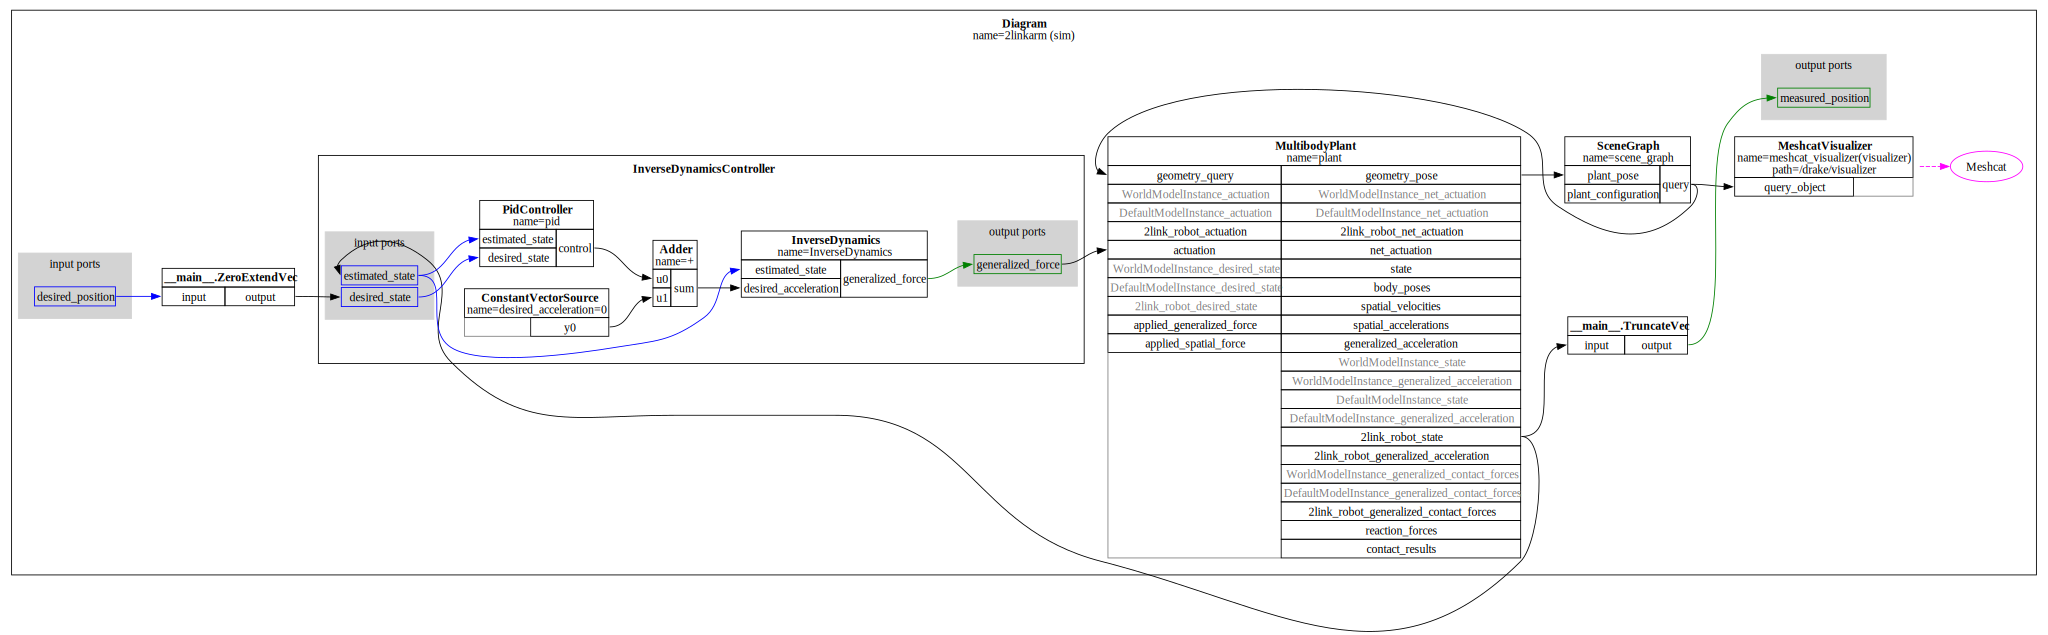

In [30]:
RenderDiagram(build_2d_link(meshcat)[0])

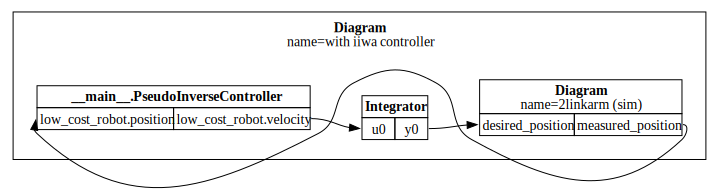

In [36]:
def jacobian_controller_example():
    # Control
    builder = DiagramBuilder()
    diagram, plant = build_2d_link(meshcat)
    controller = builder.AddSystem(PseudoInverseController(plant, model_name="2link_robot", ee_body_name="endEffector"))
    integrator = builder.AddSystem(Integrator(plant.num_positions()))
    twolink_arm = builder.AddSystem(diagram)

    builder.Connect(controller.get_output_port(), integrator.get_input_port())
    builder.Connect(integrator.get_output_port(), twolink_arm.get_input_port())
    builder.Connect(twolink_arm.get_output_port(), controller.get_input_port())
    
    diagram = builder.Build()
    diagram.set_name("with iiwa controller")

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    
    RenderDiagram(diagram, max_depth=1)
    integrator.set_integral_value(
        integrator.GetMyContextFromRoot(context),
        plant.GetPositions(
            plant.GetMyContextFromRoot(context),
            plant.GetModelInstanceByName("2link_robot"),
        ),
    )

    
    meshcat.StartRecording(set_visualizations_while_recording=True)
    simulator.AdvanceTo(1 if running_as_notebook else 0.1)
    meshcat.PublishRecording()
jacobian_controller_example()
